In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL 
import tensorflow as tf
import pathlib
import os
import shutil
import random
import math

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
current_path = os.getcwd() # get the path of this current file
print(current_path)
image_path = current_path.removesuffix("OmniModel") + "\\animals\\birbs2\\train" # prefix it to the path of the images
image_dir = pathlib.Path(image_path).with_suffix('') # get that path as a diretory.
print(image_dir.absolute())

c:\Users\ArtBot\Desktop\Python Projects\Capstone Sample\OmniModel
c:\Users\ArtBot\Desktop\Python Projects\Capstone Sample\animals\birbs2\train


In [6]:
import PIL.Image

image_count = len(list(image_dir.glob("*/*"))) #
print(image_count)
animal_imgs = {}
choosen_animals = ["CAPPED HERON","EGYPTIAN GOOSE","MANDARIN DUCK","RED TAILED HAWK", "SCARLET IBIS", "TAKAHE"]

for animal in [dir for dir in list(image_dir.iterdir()) if dir.name in choosen_animals]:
    animal_count = len(list(animal.glob("*")))
    animal_name = animal.name
    animal_imgs[animal_name] = list(animal.glob("*.jpg")) + list(animal.glob("*.jpeg")) + list(animal.glob("*.png"))
    
    print(f"Number of {animal_name} is {animal_count}, {animal_count - len(animal_imgs[animal_name])} not stored")

84635
Number of CAPPED HERON is 137, 0 not stored
Number of EGYPTIAN GOOSE is 157, 0 not stored
Number of RED TAILED HAWK is 202, 0 not stored
Number of SCARLET IBIS is 138, 0 not stored
Number of TAKAHE is 161, 0 not stored


In [7]:
testing_ratio = 0.1
data_cap = 500//(len(animal_imgs.keys()))
project_folder = "bird"

training_path = current_path + "\\"+ project_folder + "\\TrainingData"
testing_path = current_path + "\\"+ project_folder + "\\TestingData"

os.makedirs(training_path,exist_ok=True)
os.makedirs(testing_path,exist_ok=True)

for animal_dir in [dir for dir in list(image_dir.iterdir()) if dir.name in choosen_animals]:
    print("Gathering data for",animal_dir.name)
    tr_des_path = training_path + "\\" + animal_dir.name
    ts_des_path = testing_path + "\\" + animal_dir.name
    
    os.makedirs(tr_des_path,exist_ok=True)
    os.makedirs(ts_des_path,exist_ok=True)
    
    tr_dir = pathlib.Path(tr_des_path).with_suffix('')
    ts_dir = pathlib.Path(ts_des_path).with_suffix('')
    
    tr_size = len(list(tr_dir.iterdir()))
    ts_size = len(list(ts_dir.iterdir()))
    
    print("\tTraining started with",tr_size)
    print("\tTesting started with",ts_size)
    
    isfull = {"training":False,"testing":False}
    into_testing = False
    while len(animal_imgs[animal_dir.name]) > 0:
        isfull["training"] = tr_size >= (1-testing_ratio)*data_cap        
        isfull["testing"] = ts_size >= (testing_ratio)*data_cap
        
        if all(isfull.values()): break
        
        index = random.randrange(0,len(animal_imgs[animal_dir.name])) 
        img = animal_imgs[animal_dir.name].pop(index)
        try:
            full_path = str(img.absolute())
            full_path.encode("latin-1")
        except UnicodeEncodeError as e:
            print("Encoding error in file:",full_path,"\n",e)
            os.unlink(full_path)
            continue
        
        if isfull["testing"] and not isfull["training"]: shutil.copy2(full_path,str(tr_dir.absolute()))
        elif not isfull["testing"] and isfull["training"]: shutil.copy2(full_path,str(ts_dir.absolute()))
        elif not isfull["training"] and not into_testing: shutil.copy2(full_path,str(tr_dir.absolute()))
        elif not isfull["testing"] and into_testing: shutil.copy2(full_path,str(ts_dir.absolute()))
        into_testing = not(into_testing)
        
        tr_size = len(list(tr_dir.iterdir()))
        ts_size = len(list(ts_dir.iterdir()))
    
    print("\tTraining ended with",tr_size)
    print("\tTesting ended with",ts_size)               
    print()

print("finished")  

Gathering data for CAPPED HERON
	Training started with 0
	Testing started with 0
	Training ended with 90
	Testing ended with 10

Gathering data for EGYPTIAN GOOSE
	Training started with 0
	Testing started with 0
	Training ended with 90
	Testing ended with 10

Gathering data for RED TAILED HAWK
	Training started with 0
	Testing started with 0
	Training ended with 90
	Testing ended with 10

Gathering data for SCARLET IBIS
	Training started with 0
	Testing started with 0
	Training ended with 90
	Testing ended with 10

Gathering data for TAKAHE
	Training started with 0
	Testing started with 0
	Training ended with 90
	Testing ended with 10

finished


In [8]:
training_dir = pathlib.Path(training_path).with_suffix('')
testing_dir = pathlib.Path(testing_path).with_suffix('')

print("Training Info:")
print("Dir:",training_dir.absolute())
image_count = len(list(training_dir.glob("*/*")))
print(image_count)
for animal in list(training_dir.iterdir()):
    animal_count = len(list(animal.glob("*")))
    animal_name = animal.name
    print(f"Number of {animal_name} is {animal_count}")

print()

print("Testing Info: ")
print("Dir:",testing_dir.absolute())
image_count = len(list(testing_dir.glob("*/*")))
print(image_count)
for animal in list(testing_dir.iterdir()):
    animal_count = len(list(animal.glob("*")))
    animal_name = animal.name
    print(f"Number of {animal_name} is {animal_count}")

Training Info:
Dir: c:\Users\ArtBot\Desktop\Python Projects\Capstone Sample\OmniModel\bird\TrainingData
450
Number of CAPPED HERON is 90
Number of EGYPTIAN GOOSE is 90
Number of RED TAILED HAWK is 90
Number of SCARLET IBIS is 90
Number of TAKAHE is 90

Testing Info: 
Dir: c:\Users\ArtBot\Desktop\Python Projects\Capstone Sample\OmniModel\bird\TestingData
50
Number of CAPPED HERON is 10
Number of EGYPTIAN GOOSE is 10
Number of RED TAILED HAWK is 10
Number of SCARLET IBIS is 10
Number of TAKAHE is 10


In [9]:
batch_size = 32
img_h = 250
img_w = 250

train_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_h,img_w),
    batch_size = batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_h,img_w),
    batch_size = batch_size
)

class_names = train_ds.class_names
num_classes = len(list(class_names))
print(num_classes)

Found 450 files belonging to 5 classes.
Using 360 files for training.
Found 450 files belonging to 5 classes.
Using 90 files for validation.
5


In [10]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

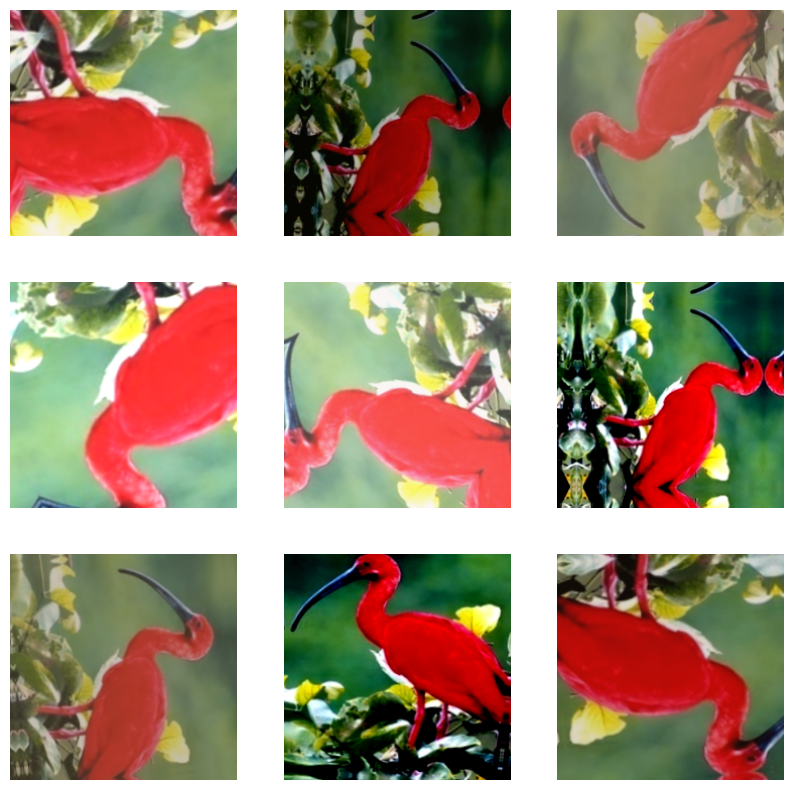

In [16]:
data_agumentor = Sequential([
    # Sharpen(),
    layers.RandomCrop(height=225,width=225,input_shape=(img_h,img_w,3)),
    layers.RandomFlip('horizontal',input_shape=(img_h,img_w,3)),
    layers.RandomZoom(0.4),
    layers.RandomBrightness(0.3),
    layers.RandomFlip('vertical',input_shape=(img_h,img_w,3)),
    layers.RandomContrast(0.6),
    layers.RandomRotation(0.3),
])

plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(9):
        aug_imgs = data_agumentor(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(aug_imgs[0].numpy().astype('uint8'))
        plt.axis("off")

In [17]:
from tensorflow.keras.optimizers import Adam

model = tf.keras.Sequential([
  data_agumentor,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(24, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer = Adam(learning_rate=0.00075), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy']
)

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 225, 225, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 225, 225, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 225, 225, 32)      896       
                                                                 
 average_pooling2d (Average  (None, 112, 112, 32)      0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                  

In [18]:
class StopAtThreshold(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', threshold=0.90):
        super(StopAtThreshold, self).__init__()
        self.monitor = monitor
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None:
            if current >= self.threshold:
                print(f"\nEpoch {epoch}: Reached {self.monitor} of {current}, stopping training.")
                self.model.stop_training = True

In [19]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
epoch_range = []

In [20]:
from IPython.display import clear_output

loss_stopping = EarlyStopping(monitor='val_loss', patience=7)
hi_acc_stopping = StopAtThreshold(monitor='val_accuracy',threshold=0.9)

slowed_count = 0
regres = False
n = 5
alpha = 0.0004
full_process = False
for i in range(1,n+1):
    clear_output(wait=True)
    
    tf.keras.backend.set_value(model.optimizer.learning_rate, alpha)
    
    print("Phase:",i,"alpha:",float(model.optimizer.learning_rate))
    epochs = 10
    training_record = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs = epochs,
        callbacks=[hi_acc_stopping]
    )

    train_acc += training_record.history['accuracy'] # getting training and validation accuracy
    val_acc += training_record.history['val_accuracy']

    train_loss += training_record.history['loss']
    val_loss += training_record.history['val_loss'] # getting training and validation loss

    last_acc = val_acc[-1]
    last_loss = val_loss[-1]
    
    #if len(train_loss)%20 == 0: alpha*= 0.75
    
    loss_diff = 0
    for i in range(epochs): loss_diff += train_loss[-(i+1)]-val_loss[-(i+1)]
    
    if loss_diff < 0.05: print("[WARNING] Learning Slowed!"); slowed_count += 1
    
    gradient = 0 # detecting learning greation. Also happens with overfitting.
    for i in range(0,epochs,2): gradient += (val_acc[i+1] - val_acc[i])/2
    gradient = gradient/(epochs//2)
    if gradient < 0 and regres:
        break
    elif gradient < -0.1: 
        print("[WARNING] Learning Regression!")
        regres = True
    elif gradient > 0:
        regres = False 
    
    if model.stop_training:break

full_process = True
print("Learing Slowed",slowed_count,"time.")

Phase: 5 alpha: 0.00039999998989515007
Epoch 1/10
12/12 [==============================] - 21s 2s/step - loss: 0.8166 - accuracy: 0.6889 - val_loss: 0.6465 - val_accuracy: 0.7778
Epoch 2/10
12/12 [==============================] - 21s 2s/step - loss: 0.7950 - accuracy: 0.6778 - val_loss: 0.6294 - val_accuracy: 0.8222
Epoch 3/10
12/12 [==============================] - 23s 2s/step - loss: 0.7586 - accuracy: 0.7083 - val_loss: 0.6412 - val_accuracy: 0.8333
Epoch 4/10
12/12 [==============================] - 23s 2s/step - loss: 0.7672 - accuracy: 0.6444 - val_loss: 0.5593 - val_accuracy: 0.8222
Epoch 5/10
12/12 [==============================] - 22s 2s/step - loss: 0.6851 - accuracy: 0.7278 - val_loss: 0.6026 - val_accuracy: 0.7778
Epoch 6/10
12/12 [==============================] - 20s 2s/step - loss: 0.7433 - accuracy: 0.7167 - val_loss: 0.5727 - val_accuracy: 0.8333
Epoch 7/10
12/12 [==============================] - 20s 2s/step - loss: 0.8370 - accuracy: 0.6750 - val_loss: 0.5980 - va

In [21]:
if not full_process:
    train_acc += training_record.history['accuracy'] # getting training and validation accuracy
    val_acc += training_record.history['val_accuracy']

    train_loss += training_record.history['loss']
    val_loss += training_record.history['val_loss'] # getting training and validation loss

In [22]:
import math
def smoothen(lst,sample_rate=0.05):
    if len(lst) == 0: return []
    rlist = []
    area = math.ceil(sample_rate * len(lst))
    for upperbound in range(len(lst)):
        lowerbound = max(0,upperbound-area)
        # print(lowerbound,upperbound)
        sample = lst[lowerbound:upperbound+1].copy()
        sample.sort()
        median = math.ceil(0.5*len(sample))
        rlist.append(sample[median-1])
    return rlist

def gradient(lst,sampling=True,sample_rate=0.25):
    if len(lst)==0:return []
    rlist = []
    area = math.ceil(sample_rate* len(lst))
    if not sampling: area = 2
    for upperbound in range(len(lst)):
        lowerbound = max(0,upperbound - area)
        sample = lst[lowerbound:upperbound+1].copy()
        gradients = [(sample[i+1] - sample[i])/2 for i in range(0,len(sample)-1,2)]
        if len(sample) == 1: gradients = [0]
        gradients.sort()
        mid = math.ceil(0.5 * len(gradients))
        
        rlist.append(gradients[mid - 1])
    return rlist

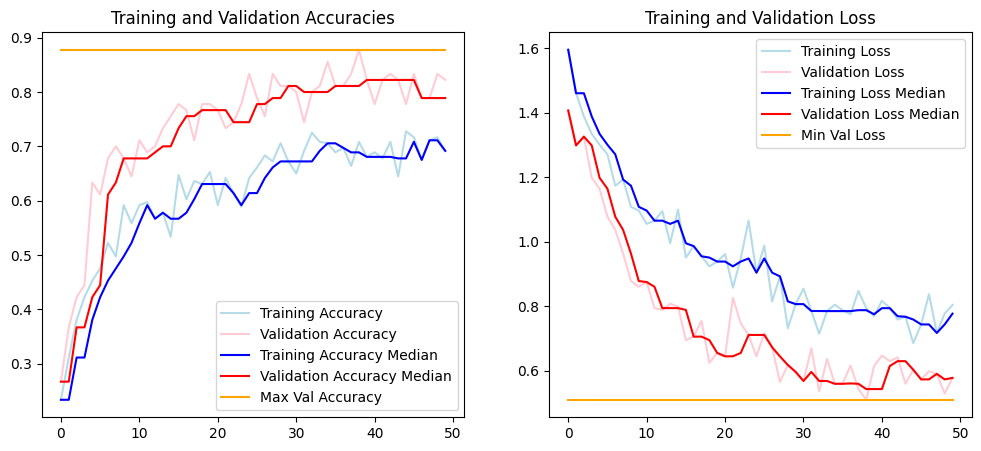

In [23]:
epoch_range = range(len(train_loss)) # getting a range for the epochs to act as a time scale.
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epoch_range,train_acc,color='lightblue',alpha= 0.9,label='Training Accuracy')
plt.plot(epoch_range,val_acc,color='pink',alpha= 0.8,label='Validation Accuracy')
plt.plot(epoch_range,smoothen(train_acc),color='blue',label='Training Accuracy Median')
plt.plot(epoch_range,smoothen(val_acc),color='red',label='Validation Accuracy Median')
plt.plot(epoch_range,[max(val_acc) for _ in range(len(epoch_range))],color='orange',label='Max Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracies')

plt.subplot(1,2,2)
plt.plot(epoch_range,train_loss,color='lightblue',alpha= 0.9,label='Training Loss')
plt.plot(epoch_range,val_loss,color='pink',alpha= 0.8,label='Validation Loss')
plt.plot(epoch_range,smoothen(train_loss),color='blue',label='Training Loss Median')
plt.plot(epoch_range,smoothen(val_loss),color='red',label='Validation Loss Median')
plt.plot(epoch_range,[min(val_loss) for _ in range(len(epoch_range))],color='orange',label='Min Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [24]:
Accuracies = {}
Var_av = {}

for animal_dir in list(testing_dir.iterdir()):
    class_count = 0
    correct_answers = 0
    scores = []
    for img_path in list(animal_dir.iterdir()):
        try:
            img = tf.keras.utils.load_img(
                img_path, target_size=(img_h, img_w)
            )
            class_count += 1
        except:
            continue

        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array,0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        scores.append(tuple(score.numpy()))
        
        if animal_dir.name == class_names[np.argmax(score)]: correct_answers += 1
    Accuracies[animal_dir.name] = correct_answers/class_count
    avgs = [sum(element[i] for element in scores)/class_count for i in range(num_classes)]
    mean_avgs = sum(avgs)/len(avgs)
    Var_av[animal_dir.name] = sum([pow(avgs[i] - mean_avgs,2) for i in range(len(avgs))]) #this migth not be saying what i want it to be saying...
    

1/1 [==============================] - 0s 29ms/step


In [25]:
print("Testing Accuracy:")
for key in Accuracies.keys():
    print("<"+key+">",Accuracies[key])

print()
print("Variance in Average Confidence")
for key in Accuracies.keys():
    print(key,"had",Var_av[key])

# bird scored 0.8571428571428571
# cat scored 0.8095238095238095
# dog scored 0.42857142857142855
# snake scored 0.9523809523809523

Testing Accuracy:
<CAPPED HERON> 0.8
<EGYPTIAN GOOSE> 0.2
<RED TAILED HAWK> 0.9
<SCARLET IBIS> 1.0
<TAKAHE> 1.0

Variance in Average Confidence
CAPPED HERON had 0.32614477317689855
EGYPTIAN GOOSE had 0.14913992936480225
RED TAILED HAWK had 0.4647682729176159
SCARLET IBIS had 0.7615110965967211
TAKAHE had 0.7620916771744598


In [26]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

saved_file_name = project_folder + "_model_v"
version_count = 1
for dir in list(pathlib.Path(current_path + "\\models").glob("*.tflite")):
    if dir.name.startswith(saved_file_name): version_count += 1
saved_file_name += str(version_count)

# Save the model.
with open('models\\'+saved_file_name+".tflite", 'wb') as f:
  f.write(tflite_model)

print("File saved as",saved_file_name)

INFO:tensorflow:Assets written to: C:\Users\ArtBot\AppData\Local\Temp\tmp9wl0gu23\assets


INFO:tensorflow:Assets written to: C:\Users\ArtBot\AppData\Local\Temp\tmp9wl0gu23\assets


File saved as bird_model_v1
